## sircat

Makes a catalog of solar wind stream interaction regions (SIRs) and high speed solar wind streams (HSS) for the Wind, STEREO and MAVEN spacecraft since 2007.

Authors: [C. Möstl](https://www.iwf.oeaw.ac.at/en/user-site/christian-moestl/) (twitter @chrisoutofspace), A. J. Weiss, R. L. Bailey, IWF Graz, Austria; Lan Jian, NASA, USA, Maxim Grandin, University of Helsinki, Finland; Hui Huang, Beijing  University, China.


**current status: work in progress** 

If you want to use parts of this code for generating results for peer-reviewed scientific publications, please contact us per email (christian.moestl@oeaw.ac.at, lan.jian@nasa.gov, maxime.grandin@helsinki.fi) for co-authorships.


part of https://github.com/cmoestl/heliocats, last update June 2020

---

### Installation 
In a command line, do: "git clone https://github.com/cmoestl/heliocats".
    
Install a specific conda environment to run this code, see README at https://github.com/cmoestl/heliocats

Download the files from https://doi.org/10.6084/m9.figshare.11973693 and place them in the /data folder.



### Updates

Adding a new SIR event: change the source files, or add the sir and hss times in section 2 before the master file sircat/HELIO4CAST_SIRCAT_v10_master.xlsx is produced. Then delete the file for the respective spacecraft under sircat/indices_sircat, and run this notebook or script.

Convert this notebook to a script with "jupyter nbconvert --to script sircat.ipynb" in a command line

---


### Data sources

**STEREO SIR list**: Lan Jian, https://stereo-ssc.nascom.nasa.gov/data/ins_data/impact/level3/
published in: L. K. Jian et al. https://doi.org/10.1007/s11207-019-1416-8, 2019.

This catalog contains the SIR start and end times, as well as the Pt max time for the stream interface. We use their SIR start and ends time as our *sir_start_time* and *sir_end_time*, set the *hss_start_time* with the Pt max time and create our own *hss_end_time* by setting it as the first time when the total bulk speed drops below 450 km/s after *sir_end_time*. For 4 Pt max times that were nan in the Jian et al. list, the *hss_start_time* has been set similar to the *sir_end_time*.




Thus, for the Jian et al. catalog all 4 times are available: *sir_start_time*, *hss_start_time* (=stream interface time), *sir_end_time*, *hss_end_time* (added by us).


**For the STEREO HSS catalog, you can opt to list only the events with the fastest speed reaching at least 500 km/s, to be consistent with Grandin et al. (2019).
For Grandin et al. (2019), you can use the peak of total pressure to approximate the stream interface time.**


**Earth SIR/HSS list**: Maxim Grandin et al., 2018, https://doi.org/10.1029/2018JA026396

This catalog directly gives the *hss_start_time* and the *hss_end_time*, with a similar definition as the *hss_end_time* that we use for the STEREO catalog. This list was determined by an algorithm and there are no specifics about the the SIR times, instead the start time is determined as the start of the increasing speed and is thus is likely closer to an SIR start time than to a stream interface time, which we use as a hss_start_time.  For simplicity, we have nevertheless taken the given start time as the hss_start_time. In future updates, we may change this time to the sir_start_time and add a proper hss_start_time by searching for ptmax after a new sir_start_time.

The Grandin et al. (2019) catalogue only contains events for which the solar wind speed reached at least 500 km/s.

The times in the Earth SIR/HSS list have been modified to 1 hour earlier as these times were originally given for the magnetopause, but the Wind spacecraft is located at the L1 point. One hour is practically equivalent to the propagation time of a 400 km/s slow solar wind from the L1 point to the magnetopause.

Thus, for the Grandin et al. catalog these 2 times are available: *hss_start_time* and *hss_end_time*.



**MARS SIR/HSS list**: Hui Huang et al., 2019, https://doi.org/10.3847/1538-4357/ab25e9 (open access not available).
This catalog gives the sir_start_time, hss_start_time (=stream interface time) and the sir_end_time. Similar to the STEREO-list, with have added the hss_end_time **add hss_end_time, plots**

**add plots transverse pressure**




All other parameters are calculated from scratch from the spacecraft data via this notebook or script.

---

### Other resourcess


**Great review on SIRs** by Ian G. Richardson: https://link.springer.com/article/10.1007/s41116-017-0011-z


---







start with importing packages, get paths from config.py file and make directories 

In [60]:
import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import  DateFormatter
from datetime import timedelta
import seaborn as sns
import datetime
import astropy
import astropy.constants as const
from sunpy.time import parse_time
import time
import pickle
import sys
import os
import urllib
import json
import importlib
import pandas as pd
import copy
import openpyxl
import h5py

from heliocats import plot as hp
importlib.reload(hp) #reload again while debugging

from heliocats import data as hd
importlib.reload(hd) #reload again while debugging

from heliocats import cats as hc
importlib.reload(hc) #reload again while debugging

from heliocats import stats as hs
importlib.reload(hs) #reload again while debugging

#where the in situ data files are located is read 
#from config.py 
import config
importlib.reload(config)
from config import data_path
from config import data_path_ML


########### make directories first time if not there

resdir='results'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

indexdir='sircat/indices_sircat' 
if os.path.isdir(indexdir) == False: os.mkdir(indexdir) 

catdir='sircat'
if os.path.isdir(catdir) == False: os.mkdir(catdir)

sirplotsdir='sircat/plots_sircat/' 
if os.path.isdir(sirplotsdir) == False: os.mkdir(sirplotsdir) 

#Convert this notebook to a script with jupyter nbconvert --to script icmecat.ipynb
os.system('jupyter nbconvert --to script sircat.ipynb')    

#in situ data files are updated via the icmecat.ipynb notebook 
    

## (1) load data 

0

## (1) load data from STEREO-B, STEREO-A, Wind, and MAVEN


In [61]:
load_data=1

if load_data > 0:    
        
    #print('load Ulysses RTN') #made with heliocats.data.save_ulysses_data
    #fileuly='ulysses_1990_2009_rtn.p'
    #[uly,huly]=pickle.load(open(data_path+fileuly, "rb" ) )      
    
    print('load STEREO-B data SCEQ') #yearly magplasma files from stereo science center, conversion to SCEQ 
    filestb='stereob_2007_2014_sceq.p'
    [stb,hstb]=pickle.load(open(data_path+filestb, "rb" ) )      
 

    ########### CURRENT ACTIVE SPACECRAFT    

    
    # ADD BepiColombo  
    
    
    # ADD Solar Orbiter
    
       
    print('load MAVEN data MSO') #removed magnetosphere by C. Simon Wedlund, 1 data point per orbit, MSO 
    #filemav='maven_2014_2018.p'
    #[mav,hmav]=pickle.load(open(filemav, 'rb' ) )
    #filemav='maven_2014_2018_removed.p'
    #[mav,hmav]=pickle.load(open(filemav, 'rb' ) )    
    filemav='maven_2014_2018_removed_smoothed.p'
    [mav,hmav]=pickle.load(open(data_path+filemav, 'rb' ) )
    
    #print('load MSL RAD')
    #MSL RAD
    #rad=hd.load_msl_rad()#, rad.time,rad.dose_sol

    
    #print('load PSP data SCEQ') #from heliosat, converted to SCEQ similar to STEREO-A/B
    #filepsp='psp_2018_2019_sceq.p'
    #[psp,hpsp]=pickle.load(open(data_path+filepsp, "rb" ) )     
    
    print('load and merge STEREO-A data SCEQ') #yearly magplasma files from stereo science center, conversion to SCEQ 
    filesta1='stereoa_2007_2019_sceq.p'
    [sta1,hsta1]=pickle.load(open(data_path+filesta1, "rb" ) )  
    sta1=sta1[np.where(sta1.time < parse_time('2019-Sep-01 00:00').datetime)[0]]

    #beacon data
    filesta2="stereoa_2019_2020_sceq_beacon.p"
    [sta2,hsta2]=pickle.load(open(data_path+filesta2, "rb" ) )  
    sta2=sta2[np.where(sta2.time >= parse_time('2019-Sep-01 00:00').datetime)[0]]

    #make array
    sta=np.zeros(np.size(sta1.time)+np.size(sta2.time),dtype=[('time',object),('bx', float),('by', float),\
                ('bz', float),('bt', float),('vt', float),('np', float),('tp', float),\
                ('x', float),('y', float),('z', float),\
                ('r', float),('lat', float),('lon', float)])   

    #convert to recarray
    sta = sta.view(np.recarray)  
    sta.time=np.hstack((sta1.time,sta2.time))
    sta.bx=np.hstack((sta1.bx,sta2.bx))
    sta.by=np.hstack((sta1.by,sta2.by))
    sta.bz=np.hstack((sta1.bz,sta2.bz))
    sta.bt=np.hstack((sta1.bt,sta2.bt))
    sta.vt=np.hstack((sta1.vt,sta2.vt))
    sta.np=np.hstack((sta1.np,sta2.np))
    sta.tp=np.hstack((sta1.tp,sta2.tp))
    sta.x=np.hstack((sta1.x,sta2.x))
    sta.y=np.hstack((sta1.y,sta2.y))
    sta.z=np.hstack((sta1.z,sta2.z))
    sta.r=np.hstack((sta1.r,sta2.r))
    sta.lon=np.hstack((sta1.lon,sta2.lon))
    sta.lat=np.hstack((sta1.lat,sta2.lat))
    print('STA Merging done')

    
    
    print('load and merge Wind data HEEQ') 
    #from HELCATS HEEQ until 2018 1 1 + new self-processed data with heliosat and hd.save_wind_data
    filewin="wind_2007_2018_heeq_helcats.p" 
    [win1,hwin1]=pickle.load(open(data_path+filewin, "rb" ) )  
    
    #or use: filewin2="wind_2018_now_heeq.p" 
    filewin2="wind_2018_2019_heeq.p" 
    [win2,hwin2]=pickle.load(open(data_path+filewin2, "rb" ) )  

    #merge Wind old and new data 
    #cut off HELCATS data at end of 2017, win2 begins exactly after this
    win1=win1[np.where(win1.time < parse_time('2018-Jan-01 00:00').datetime)[0]]
    #make array
    win=np.zeros(np.size(win1.time)+np.size(win2.time),dtype=[('time',object),('bx', float),('by', float),\
                ('bz', float),('bt', float),('vt', float),('np', float),('tp', float),\
                ('x', float),('y', float),('z', float),\
                ('r', float),('lat', float),('lon', float)])   

    #convert to recarray
    win = win.view(np.recarray)  
    win.time=np.hstack((win1.time,win2.time))
    win.bx=np.hstack((win1.bx,win2.bx))
    win.by=np.hstack((win1.by,win2.by))
    win.bz=np.hstack((win1.bz,win2.bz))
    win.bt=np.hstack((win1.bt,win2.bt))
    win.vt=np.hstack((win1.vt,win2.vt))
    win.np=np.hstack((win1.np,win2.np))
    win.tp=np.hstack((win1.tp,win2.tp))
    win.x=np.hstack((win1.x,win2.x))
    win.y=np.hstack((win1.y,win2.y))
    win.z=np.hstack((win1.z,win2.z))
    win.r=np.hstack((win1.r,win2.r))
    win.lon=np.hstack((win1.lon,win2.lon))
    win.lat=np.hstack((win1.lat,win2.lat))

    print('Wind merging done')
    
    
         
print()
    
print()       
print('time ranges of the in situ data: ')    
print()
print('active spacecraft:')
print('Wind                 ',str(win.time[0])[0:10],str(win.time[-1])[0:10])
print('STEREO-A             ',str(sta.time[0])[0:10],str(sta.time[-1])[0:10])
#print('Parker Solar Probe   ',str(psp.time[0])[0:10],str(psp.time[-1])[0:10])
print('MAVEN                ',str(mav.time[0])[0:10],str(mav.time[-1])[0:10])
#print('MSL/RAD              ',str(rad.time[0])[0:10],str(rad.time[-1])[0:10])
print()
print('missions finished:')
#print('VEX                  ',str(vex.time[0])[0:10],str(vex.time[-1])[0:10])
#print('MESSENGER            ',str(mes.time[0])[0:10],str(mes.time[-1])[0:10])
print('STEREO-B             ',str(stb.time[0])[0:10],str(stb.time[-1])[0:10])
#print('Ulysses              ',str(uly.time[0])[0:10],str(uly.time[-1])[0:10])
print()
# print('catalogs:')
# print()
# print('HELCATS HIGeoCAT     ',str(higeocat_time[0])[0:10],str(higeocat_time[-1])[0:10])



print('done')

load STEREO-B data SCEQ
load MAVEN data MSO
load and merge STEREO-A data SCEQ
STA Merging done
load and merge Wind data HEEQ
Wind merging done


time ranges of the in situ data: 

active spacecraft:
Wind                  2007-01-01 2019-12-31
STEREO-A              2007-01-01 2020-04-15
MAVEN                 2014-09-22 2018-01-31

missions finished:
STEREO-B              2007-01-01 2014-09-27

done


## (2) make SIRCAT masterfile from STEREO and Wind catalogs

Here we read raw STEREO SIR and Earth SIR catalogs from Lan Jian, Maxim Grandin, and Hui Huang et al. and convert to master catalog xlsx file that contains all times in a consistent way.

In [100]:
###################### read raw STEREO SIR catalog

file='sircat/sources/STEREO_Level3_SIR_data.xlsx'
print('load Jian STEREO catalog from excel file:', file)
sraw=pd.read_excel(file)

#get 2 times: HSS start (equivalent to SIR start as defined in the L. Jian catalog), HSS end (where speed again < 450km/s)

print('Events in STEREO SIR cat:', sraw.shape[0])
print()


sc=sraw.loc[:,'spacecraft']
year_start=sraw.loc[:,'year_start']
stime=sraw.loc[:,'start_time']

year_end=sraw.loc[:,'year_end']
etime=sraw.loc[:,'end_time']

year_pt=sraw.loc[:,'year_pt']
ptime=sraw.loc[:,'pt_time']

#make list for all basic times, ids etc. for master file
rows_list = []

for i in np.arange(0,sraw.shape[0]):
    
    

    s=stime[i]    
    y=year_start[i]
    doy=int(s[0:3])
    hour=int(s[-5:-3])
    minute=int(s[-2:])
    #print(y,doy,hour, min)
    sir_start_time=datetime.datetime(y,1,1)+timedelta(days=doy-1)+timedelta(hours=hour)+timedelta(minutes=minute)

    e=etime[i]    
    y=year_end[i]
    doy=int(e[0:3])
    hour=int(e[-5:-3])
    minute=int(e[-2:])
    #print(y,doy,hour, min)
    sir_end_time=datetime.datetime(y,1,1)+timedelta(days=doy-1)+timedelta(hours=hour)+timedelta(minutes=minute)

    #print(i)
    p=ptime[i]    
    #print(ptime[i])
    y=year_pt[i]
    doy=int(p[0:3])
    hour=int(p[-5:-3])
    minute=int(p[-2:])
    #print(y,doy,hour, min)
    hss_start_time=datetime.datetime(y,1,1)+timedelta(days=doy-1)+timedelta(hours=hour)+timedelta(minutes=minute)
    
    
    #make id for event    
    id_time=parse_time(hss_start_time).isot
    if sc[i]=='A': sc_idstring='SIR_STEREO_A_JIAN_'
    if sc[i]=='B': sc_idstring='SIR_STEREO_B_JIAN_'

    if sc[i]=='A': sc_string='STEREO-A'
    if sc[i]=='B': sc_string='STEREO-B'
        
    sircat_id=sc_idstring+id_time[0:4]+id_time[5:7]+id_time[8:10]+'_01'
    
    #put all data for this event in a list
    list1 = [sircat_id,sc_string,parse_time(sir_start_time).isot,parse_time(hss_start_time).isot, parse_time(sir_end_time).isot,np.nan,np.nan,np.nan,np.nan,\
             np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,\
             np.nan,np.nan,np.nan]
    
    #print(list1)    
    #append to full list
    rows_list.append(list1)
    

########################## read raw Wind catalog

#Grandin et al. 2018 - OMNI
#removed 2 SIRs due to data gap of Wind in oct 2014
filewin='sircat/sources/grandin_2018_list_modified.txt'
wraw=np.loadtxt(filewin,skiprows=9)
print('load Grandin Earth HSS catalog from:', filewin)
print('Events in Wind SIR/HSS cat:', wraw.shape[0])
print()

#2 times: SIR/HSS start, HSS end (where speed again < 450km/s)

#begin with 2007
begin2007=np.where(wraw[:,1]>=2007)[0][0]


for i in np.arange(begin2007,len(wraw),1):

    
    #SIR HSS start time y,m,d,h,m - minus 1 hour for Wind at L1, not magnetopause
    wstart=datetime.datetime(wraw[i,1].astype(int),wraw[i,2].astype(int), \
                             wraw[i,3].astype(int),wraw[i,4].astype(int), \
                             0)-datetime.timedelta(hours=1) 
    #SIR HSS end time y,m,d,h,m - minus 1 hour for Wind at L1, not magnetopause
    wend=datetime.datetime(wraw[i,11].astype(int),wraw[i,12].astype(int), \
                             wraw[i,13].astype(int),wraw[i,14].astype(int), \
                             0)-datetime.timedelta(hours=1)


    sc_idstring='SIR_WIND_GRANDIN_'
    id_time=parse_time(wstart).isot
    sircat_id=sc_idstring+id_time[0:4]+id_time[5:7]+id_time[8:10]+'_01'
    sc_string='Wind'
    
    list2 = [sircat_id,sc_string,np.nan,parse_time(wstart).isot,np.nan,parse_time(wend).isot,np.nan,np.nan,np.nan,\
             np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,\
             np.nan,np.nan,np.nan]
    
    #print(list2)

    rows_list.append(list2)


    
    
########################## read MAVEN catalog   

from heliocats import data as hd
importlib.reload(hd) #reload again while debugging

#this is a recarray    
mavsir_all=hd.load_maven_sir_huang()

#check which events overlap with the available MAVEN data (cutoff at -10)
mavsir_ind=np.where(mavsir_all.start < mav.time[-1])[0][0:-10]
mavsir=mavsir_all[mavsir_ind]
   
print('Events in MAVEN SIR/HSS cat:', mavsir.shape[0])
print()


#go through all events
for i in mavsir_ind:
    
    sc_idstring='SIR_MAVEN_HUANG_'
    id_time=parse_time(mavsir.start[i][0]).isot
    sircat_id=sc_idstring+id_time[0:4]+id_time[5:7]+id_time[8:10]+'_01'
    sc_string='MAVEN'
   
    list3 = [sircat_id,sc_string,parse_time(mavsir.start[i][0]).isot,parse_time(mavsir.si[i][0]).isot,parse_time(mavsir.end[i][0]).isot,np.nan,np.nan,np.nan,np.nan,\
             np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,\
             np.nan,np.nan,np.nan]
    
    #print(list3)

    rows_list.append(list3)


    
    
###################################  add new events **** to be done
#for measuring new events use this function from heliocats.plot 
#plt.close('all')
#works in jupyter notebooks

#works in scripts
#matplotlib.use('qt5agg')  
#plt.ion()

#STEREO-A
#hp.plot_insitu_measure(sta, '2018-Jan-01 12:00','2018-Feb-01 12:00', 'STEREO-A', 'results/')

#Wind
#hp.plot_insitu_measure(win, '2019-Jan-29','2019-Feb-28', 'Wind', 'results/')

    
    
    
################ make pandas data frame for master file
        
parameters =['sircat_id','sc_insitu','sir_start_time','hss_start_time','sir_end_time',\
             'hss_end_time','hss_vtmax_time','sc_heliodistance',\
             'sc_long_heeq', 'sc_lat_heeq', 
             'hss_vtmax','hss_vtmean','hss_vtstd','hss_btmax','hss_btmean',\
             'hss_btstd','hss_bzmin', 'hss_bzmean','hss_bzstd','hss_duration',\
             'sir_vtmax','sir_vtmean', 'sir_vtstd','sir_btmax','sir_btmean',\
             'sir_btstd','sir_bzmin', 'sir_bzmean','sir_bzstd','sir_duration']


master=pd.DataFrame(rows_list,columns=parameters)

#sort by spacecraft indicator and start time
master=master.sort_values(['sc_insitu','hss_start_time'])
master = master.reset_index(drop=True) #drop extra index value

master


#save master file as Excel
file='sircat/HELIO4CAST_SIRCAT_v10_master.xlsx'
master.to_excel(file,sheet_name='SIRCATv1.0')
print()
print('SIRCAT master saved as '+file)
print('total events', master.shape[0])
print('done')

load Jian STEREO catalog from excel file: sircat/sources/STEREO_Level3_SIR_data.xlsx
Events in STEREO SIR cat: 654

load Grandin Earth HSS catalog from: sircat/sources/grandin_2018_list_modified.txt
Events in Wind SIR/HSS cat: 586

load MAVEN Huang SIR catalog from  sircat/sources/Huang_2019_SIR_MAVEN_table_1.xlsx
Events in MAVEN SIR/HSS cat: 78


SIRCAT master saved as sircat/HELIO4CAST_SIRCAT_v10_master.xlsx
total events 1008
done


## (3) make SIRCAT 

load HELCATS SIRCAT from file: sircat/HELIO4CAST_SIRCAT_v10_master.xlsx
done
Get parameters for  Wind
position
hss
sir
Get parameters for  STEREO-A
position
hss
sir
Get parameters for  STEREO-B
position
hss
sir
Get parameters for  MAVEN
position
hss
sir
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070226_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070306_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070311_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070324_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070402_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070408_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070422_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070427_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070507_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070518_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A_JIAN_20070604_01.png
saved as  sircat/plots_sircat/SIR_STEREO_A

KeyboardInterrupt: 

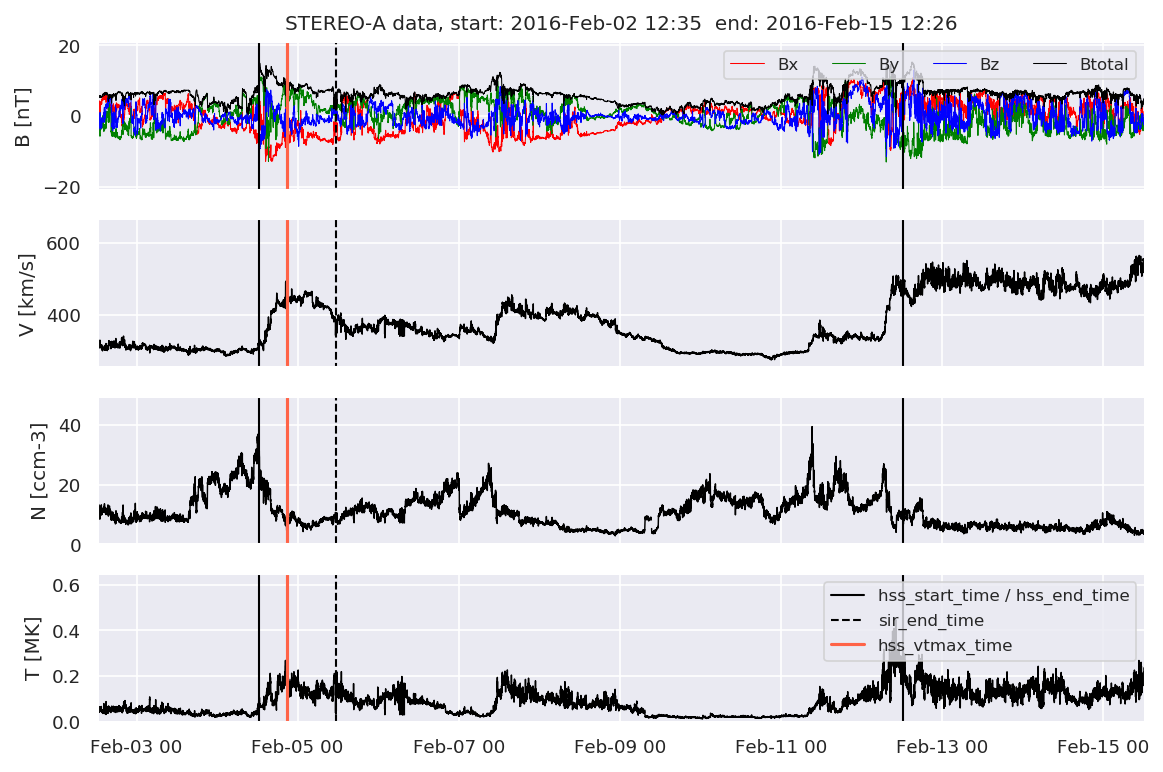

In [102]:
from heliocats import cats as hc
importlib.reload(hc) #reload again while debugging

from heliocats import plot as hp
importlib.reload(hp) #reload again while debugging

#load master file
scat=hc.load_helio4cast_sircat_master_from_excel('sircat/HELIO4CAST_SIRCAT_v10_master.xlsx')
scat


####### 3a get indices for all spacecraft
wini=np.where(scat.sc_insitu == 'Wind')[:][0] 
stai=np.where(scat.sc_insitu == 'STEREO-A')[:][0]    
stbi=np.where(scat.sc_insitu == 'STEREO-B')[:][0]    
mavi=np.where(scat.sc_insitu == 'MAVEN')[:][0]    

print('done')

####### 3b get parameters for all spacecraft one after another
# remove indices if the  events in the master file have changed
#os.system('rm sircat/indices_sircat/SIRCAT_indices_Wind.p')
#os.system('rm sircat/indices_sircat/SIRCAT_indices_STEREO-A.p')
#os.system('rm sircat/indices_sircat/SIRCAT_indices_STEREO-B.p')
#os.system('rm sircat/indices_sircat/SIRCAT_indices_MAVEN.p')

scat=hc.get_sircat_parameters(win,wini,scat,'Wind')
scat=hc.get_sircat_parameters(sta,stai,scat,'STEREO-A')
scat=hc.get_sircat_parameters(stb,stbi,scat,'STEREO-B')
scat=hc.get_sircat_parameters(mav,mavi,scat,'MAVEN')

# ###### 3c make all plots if wanted
matplotlib.use('Agg')
# hp.plot_sircat_events(sta,stai,scat,'STEREO-A',sirplotsdir)
# hp.plot_sircat_events(stb,stbi,scat,'STEREO-B',sirplotsdir)
# hp.plot_sircat_events(win,wini,scat,'Wind',sirplotsdir)
# hp.plot_sircat_events(mav,mavi,scat,'MAVEN',sirplotsdir)




print('done')


### (4) save SIRCAT 

### 4a save header

In [77]:
#save header and parameters as text file and prepare for html website
header='SIR CATALOGUE v1.0 \n\n\
This is the HELIO4CAST stream interaction region (SIR) and high speed stream (HSS) catalog,\n\
based on in situ magnetic field and bulk plasma observations in the heliosphere. \n\
It is a merged catalog created from individual ones made by Lan Jian et al. and Maxim Grandin et al. (see references).\n\n\
This is version 1.0, released 2020-06-**. DOI: ********* \n\n\
The catalog is available as  python pandas dataframe (pickle), json, csv, xlsx, txt, html at \n\
https://helioforecast.space/sircat \n\n\
Number of events in SIRCAT: '+str(len(scat))+' \n\
ICME observatories: Wind, STEREO-A, STEREO-B.   \n\
Time range: January 2007 - December 2017 (Wind), January 2007 - July 2018 (STEREO). December 2014 - January 2018 (MAVEN). \n\n\
Authors: Christian Moestl, Andreas J. Weiss, R. L. Bailey, Martin A. Reiss, Space Research Institute, \
Austrian Academy of Sciences, Graz, Austria. \n\
Lan Jian, NASA, USA; Maxim Grandin, University of Helsinki, Finland; Hui Huang, Beijing University, China. \n\n\
Rules: If results are produced with this catalog for peer-reviewed scientific publications, \n\
please contact christian.moestl@oeaw.ac.at, lan.jian@nasa.gov, maxime.grandin@helsinki.fi for possible co-authorships. \n\n\
This catalog has been made by getting the start and end times of each high speed stream from the \n\
individual catalogs, and then calculating all parameters again consistently from the data by us. \n\
The in situ data that were used for the creating catalog, with a size of 8 GB in total, including extra data \n\
files with magnetic field components in RTN coordinates and other spacecrat that are not used for producing this catalog, \n\
can be downloaded in python pickle format as recarrays from https://doi.org/10.6084/m9.figshare.11973693.v7 \n\
The python code for producing this catalog is available at https://github.com/cmoestl/heliocats sircat.ipynb \n\n\
Each sircat_id has a tag in it that indicates from which catalog the ICME times were taken: \n\n\
Wind:       Grandin et al. (2018), tag: GRANDIN \n\
STEREO-A:   Jian et al. (2019), tag: JIAN. \n\
STEREO-B:   Jian et al. (2019), tag: JIAN. \n\
MAVEN:      Huang et al. (2019), tag: HUANG. \n\n\
References \n\
Grandin, M. et al. (2018), https://doi.org/10.1029/2018JA026396. \n\
Jian, L. et al. (2019), https://doi.org/10.1007/s11207-019-1416-8. \n\
Huang, H. et al. (2019), https://doi.org/10.3847/1538-4357/ab25e9. \n\n\
Comments: \n\
- The STEREO catalog contains the SIR start and end times. We use their SIR start time as our hss_start_time, \n\
and create our hss_end_time by setting it as the first time when the total bulk speed drops below 450 km/s \n\
after the SIR end time given in the Jian catalog. \n\
Thus, for the Jian catalog there exists 3 times: hss_start_time, sir_end_time, hss_end_time.\n\
- Earth SIR/HSS list: This catalog directly gives the hss_start_time and the hss_end_time,  \n\
with a similar definition as the hss_end_time that we use for the STEREO catalog. \n\
- The times in the Earth SIR/HSS list have been modified to 1 hour earlier as these times were \n\
originally given for the magnetopause, but the Wind spacecraft is located at the L1 point. \n\
One hour is practically equivalent to the propagation time of a 400 km/s slow solar wind \n\
from the L1 point to the magnetopause.\n\
- Spacecraft positions are given in Heliocentric Earth Equatorial Coordinates (HEEQ) coordinates. \n\
- The coordinate system for all magnetic field components is SCEQ, except for Wind (HEEQ, which is the equivalent for SCEQ for Earth). \n\
        Definition of SpaceCraft Equatorial Coordinates (SCEQ): \n\
        Z is the solar rotation axis. \n\
        Y is the cross product of Z and R, with R being the vector that points from the Sun to the spacecraft.\n\
        X completes the right handed triad (and points away from the Sun). \n\
This system is thus like HEEQ but centered on the respective in situ spacecraft, so the SCEQ X and Y \n\
base vectors are rotated by the HEEQ longitude of the in situ spacecraft from HEEQ X and Y.\n\
The Y vector is similar to the T vector in an RTN system for each spacecraft, but the X and Z vectors \n\
are rotated around Y compared to an RTN system. The differences between RTN and SCEQ for spacecraft within \n\
a few degrees of the solar equatorial plane are very small (within a few 0.1 nT usually).\n\
We choose SCEQ because it has the advantage that a comparison between multipoint CME events \n\
and for comparison to simulations there is always a similar reference plane (the solar equatorial plane). \n\n '     



parameters_text='Parameters:\n\
00: sircat_id: The unique identifier for the observed ICME. unit: string. \n\
01: sc insitu: The name of the in situ observing spacecraft. unit: string. \n\
02: hss_start_time: High speed stream start time. unit: UTC. \n\
03: sir_end_time: End time of the stream interaction region. unit: UTC. \n\
04: hss_end_time: High speed stream end time, speed < 450 km/s. unit: UTC. \n\
05: hss_vtmax_time: High speed stream maxmimum speed time. unit: UTC. \n\
06: sc_heliodistance: Heliocentric distance of the spacecraft at hss_start_time. unit: AU.\n\
07: sc_long_heeq: Heliospheric longitude of the spacecraft at hss_start_time, range [-180,180]. unit: degree (HEEQ).\n\
08: sc_lat_heeq: Heliospheric latitude of the spacecraft at hss_start_time, range [-90,90]. unit: degree (HEEQ).\n\
09: hss_vt_max: Maximum proton speed from hss_start_time to hss_end_time. unit: km/s.\n\.\n\''


# 24: mo_speed_std: Standard deviation of proton speed from mo_start_time to mo_end_time. unit: km/s.\n\
# 25: mo_expansion_speed: Difference between proton speed at mo_start_time to proton speed at mo_end_time. unit: km/s.\n\

# 08: icme_duration: Duration of the interval between icme_start_time and mo_endtime. unit: hours.\n\
# 09: icme_bmax: Maximum total magnetic field in the full icme interval (icme_start_time to mo_end_time). unit: nT.\n\
# 10: icme_bmean: Mean total magnetic field during the full icme interval (icme_start_time to mo_end_time). unit: nT.\n\
# 11: icme_bstd: Standard deviation of the total magnetic field from icme_start_time to mo_end_time. unit: nT.\n\
# 12: icme_speed_mean: Mean proton speed from icme_start_time to mo_end_time. unit: km/s.\n\
# 13: icme_speed_std: Standard deviation of proton speed from icme_start_time to mo_end_time. unit: km/s.\n\
# 14: mo_duration: Duration of the interval between mo_start_time and mo_endtime. unit: hours.\n\
# 15: mo_bmax: Maximum total magnetic field in the magnetic obstacle interval (mo_start_time to mo_end_time). unit: nT.\n\
# 16: mo_bmean: Mean total magnetic field in the magnetic obstacle. unit: nT.\n\
# 17: mo_bstd: Standard deviation of the total magnetic field in the magnetic obstacle. unit: nT.\n\
# 18: mo_bzmean: Mean magnetic field Bz component in the magnetic obstacle. unit: nT.\n\
# 19: mo_bzmin: Minimum magnetic field Bz component in the magnetic obstacle. unit: nT.\n\
# 20: mo_bzstd: Standard deviation of the magnetic field Bz component in the magnetic obstacle. unit: nT.'


# #parameters =['sircat_id','sc_insitu','hss_start_time','sir_end_time',\
#              'hss_end_time','hss_vtmax_time','sc_heliodistance',\
#              'sc_long_heeq', 'sc_lat_heeq', 
#              'hss_vtmax','hss_vtmean','hss_vtstd','hss_btmax','hss_btmean',\
#              'hss_btstd','hss_bzmin', 'hss_bzmean','hss_bzstd','hss_duration',\
#              'sir_vtmax','sir_vtmean', 'sir_vtstd','sir_btmax','sir_btmean',\
#              'sir_btstd','sir_bzmin', 'sir_bzmean','sir_bzstd','sir_duration']


print(header)
print(parameters_text)


#make header file
file='sircat/HELIO4CAST_SIRCAT_v10_header.txt'
with open(file, "w") as text_file:
    text_file.write(header)
    text_file.write(parameters_text)
print()    
print('header saved as '+file)
print()    

#Convert to html regarding line breaks, paragraph beginning and spaces
header_spaces=header.replace(" ", "&nbsp;")
header_html= "<p>" +header_spaces.replace('\n', '<br>')+ "</p>" 
parameters_spaces=parameters_text.replace(" ", "&nbsp;")
parameters_html= "<p>" +parameters_text.replace('\n', '<br>')+ "</p>"
print('header converted to HTML')
print()    
print()    

SIR CATALOGUE v1.0 

This is the HELIO4CAST stream interaction region (SIR) and high speed stream (HSS) catalog,
based on in situ magnetic field and bulk plasma observations in the heliosphere. 
It is a merged catalog created from individual ones made by Lan Jian et al. and Maxim Grandin et al. (see references).

This is version 1.0, released 2020-06-**. DOI: ********* 

The catalog is available as  python pandas dataframe (pickle), json, csv, xlsx, txt, html at 
https://helioforecast.space/sircat 

Number of events in SIRCAT: 1019 
ICME observatories: Wind, STEREO-A, STEREO-B.   
Time range: January 2007 - December 2017 (Wind), January 2007 - July 2018 (STEREO). December 2014 - January 2018 (MAVEN). 

Authors: Christian Moestl, Andreas J. Weiss, R. L. Bailey, Martin A. Reiss, Space Research Institute, Austrian Academy of Sciences, Graz, Austria. 
Lan Jian, NASA, USA; Maxim Grandin, University of Helsinki, Finland; Hui Huang, Beijing University, China. 

Rules: If results are produced 

### 4b save into different formats

In [80]:
########## python formats

# save ICMECAT as pandas dataframe with times as datetime objects as pickle
file='sircat/HELIO4CAST_SIRCAT_v10_pandas.p'
pickle.dump([scat,header,parameters], open(file, 'wb'))
print('SIRCAT saved as '+file)



#load sircat as pandas dataframe
file='sircat/HELIO4CAST_SIRCAT_v10_pandas.p'
[scat_pandas,h,p]=pickle.load( open(file, 'rb'))   
scat.keys()
scat



# # save SIRCAT as numpy array with times as matplotlib datetime as pickle
# scat_num=copy.deepcopy(scat) 
# scat_num.icme_start_time=parse_time(scat_num.icme_start_time).plot_date
# scat_num.mo_start_time=parse_time(scat_num.mo_start_time).plot_date
# scat_num.mo_end_time=parse_time(scat_num.mo_end_time).plot_date
# #convert to recarray
# scat_num_rec=scat_num.to_records()
# #create structured array
# dtype1=[('index','i8'),('icmecat_id', '<U30'),('sc_insitu', '<U20')] +[(i, '<f8') for i in ic.keys()[2:len(ic.keys())]]
# scat_num_struct=np.array(scat_num_rec,dtype=dtype1)



# file='icmecat/HELIO4CAST_ICMECAT_v20_numpy.p'
# pickle.dump([scat_num,scat_num_struct,header,parameters], open(file, 'wb'))
# print('ICMECAT saved as '+file)



################ save to different formats

#copy pandas dataframe first to change time format consistent with HELIO4CAST
scat_copy=copy.deepcopy(scat)  
scat_copy.sir_start_time=parse_time(scat.sir_start_time).isot
scat_copy.hss_start_time=parse_time(scat.hss_start_time).isot
scat_copy.sir_end_time=parse_time(scat.sir_end_time).isot
scat_copy.hss_end_time=parse_time(scat.hss_end_time).isot
scat_copy.hss_vtmax_time=parse_time(scat.hss_vtmax_time).isot

scat_copy.at[stai,'sir_end_time']=parse_time(scat.sir_end_time[stai]).isot

scat_copy.at[stbi,'sir_end_time']=parse_time(scat.sir_end_time[stbi]).isot




#change time format
for i in np.arange(len(scat)):

    dum=scat_copy.hss_start_time[i] 
    scat_copy.at[i,'hss_start_time']=dum[0:16]+'Z'
    
    dum=scat_copy.hss_end_time[i] 
    scat_copy.at[i,'hss_end_time']=dum[0:16]+'Z'

    dum=scat_copy.hss_vtmax_time[i] 
    scat_copy.at[i,'hss_vtmax_time']=dum[0:16]+'Z'



     

for i in stbi:
    dum=scat_copy.sir_end_time[i] 
    scat_copy.at[i,'sir_end_time']=dum[0:16]+'Z'

for i in stai:
    dum=scat_copy.sir_end_time[i] 
    scat_copy.at[i,'sir_end_time']=dum[0:16]+'Z'
    




#save as Excel
file='sircat/HELIO4CAST_SIRCAT_v10.xlsx'
scat_copy.to_excel(file,sheet_name='SIRCATv1.0')
print('SIRCAT saved as '+file)

#save as json
file='sircat/HELIO4CAST_SIRCAT_v10.json'
scat_copy.to_json(file)
print('SIRCAT saved as '+file)

#save as csv
file='sircat/HELIO4CAST_SIRCAT_v10.csv'
scat_copy.to_csv(file)
print('SIRCAT saved as '+file)

#save as txt
file='sircat/HELIO4CAST_SIRCAT_v10.txt'
np.savetxt(file, scat_copy.values.astype(str), fmt='%s' )
print('SIRCAT saved as '+file)






#########################


# #########save into hdf5 format , use S for strings http://docs.h5py.org/en/stable/strings.html#what-about-numpy-s-u-type
# dtype2=[('index','i8'),('icmecat_id', 'S30'),('sc_insitu', 'S20')] +[(i, '<f8') for i in ic.keys()[2:len(ic.keys())]]
# ich5=np.array(scat_num_rec,dtype=dtype2)
# file='icmecat/HELIO4CAST_ICMECAT_v20.h5'
# f=h5py.File(file,mode='w')
# f["icmecat"]= ich5
# #add attributes
# #************************
# #***********************

# print('ICMECAT saved as '+file)
# f.close()

# #reading h5py files http://docs.h5py.org/en/latest/quick.html
# #fr = h5py.File('icmecat/HELIO4CAST_ICMECAT_v20.h5', 'r')
# #list(fr.keys())
# #ich5=fr['icmecat']
# #ich5['mo_bstd']
# #ich5.dtype
# #fr.close()
# ##################


# #save as .npy without pickle
# file='icmecat/HELIO4CAST_ICMECAT_v20_numpy.npy'
# np.save(file,ich5, allow_pickle=False)
# print('ICMECAT saved as '+file)

# #for loading do:
# #icnpy=np.load(file)
# #decode strings:
# #icnpy['icmecat_id'][0].decode()


#copy pandas dataframe first to change time format consistent with HELIO4CAST
scat_copy2=copy.deepcopy(scat)  
scat_copy2.hss_start_time=parse_time(scat.hss_start_time).iso
scat_copy2.hss_end_time=parse_time(scat.hss_end_time).iso
scat_copy2.hss_vtmax_time=parse_time(scat.hss_vtmax_time).iso


scat_copy2.at[stai,'sir_end_time']=parse_time(scat.sir_end_time[stai]).iso
scat_copy2.at[stbi,'sir_end_time']=parse_time(scat.sir_end_time[stbi]).iso



#change time format
for i in np.arange(len(scat)):

    dum=scat_copy2.hss_start_time[i] 
    scat_copy2.at[i,'hss_start_time']=dum[0:16]
    
    dum=scat_copy2.hss_end_time[i] 
    scat_copy2.at[i,'hss_end_time']=dum[0:16]
            
    dum=scat_copy2.hss_vtmax_time[i] 
    scat_copy2.at[i,'hss_vtmax_time']=dum[0:16]


     

for i in stbi:
    dum=scat_copy2.sir_end_time[i] 
    scat_copy2.at[i,'sir_end_time']=dum[0:16]

for i in stai:
    dum=scat_copy2.sir_end_time[i] 
    scat_copy2.at[i,'sir_end_time']=dum[0:16]
    




#save as json for webpage with different time format
file='sircat/HELIO4CAST_SIRCAT_v10_isot.json'
scat_copy2.to_json(file)
print('SIRCAT saved as '+file)



#save as html no header
file='sircat/HELIO4CAST_SIRCAT_v10_simple.html'
scat_copy.to_html(file)
print('SIRCAT saved as '+file)


############ save as html file with header
#save as html
file='sircat/HELIO4CAST_SIRCAT_v10.html'
#ic.to_html(file,justify='center')

#ichtml='{% extends "_base.html" %} \n \n {% block content %} \n \n \n '
ichtml = header_html
ichtml += parameters_html
ichtml += scat_copy.to_html()
#ichtml +='\n \n {% endblock %}'


with open(file,'w') as f:
    f.write(ichtml)
    f.close()
    
print('SIRCAT saved as '+file)    


SIRCAT saved as sircat/HELIO4CAST_SIRCAT_v10_pandas.p


ValueError: Input values did not match any of the formats where the format keyword is optional: {'datetime': TypeError('Input values for datetime class must be datetime objects'), 'ymdhms': ValueError('input must be dict or table-like'), 'iso': TypeError('Input values for iso class must be strings'), 'isot': TypeError('Input values for isot class must be strings'), 'yday': TypeError('Input values for yday class must be strings'), 'datetime64': TypeError('Input values for datetime64 class must be datetime64 objects'), 'fits': TypeError('Input values for fits class must be strings'), 'byear_str': TypeError('Input values for byear_str class must be strings'), 'jyear_str': TypeError('Input values for jyear_str class must be strings'), 'astropy_time': TypeError('Input values for astropy_time class must all be same astropy Time type.')}

## 4c load ICMECAT pickle files

In [18]:

#load sircat as pandas dataframe
file='sircat/HELIO4CAST_SIRCAT_v10_pandas.p'
[scat_pandas,h,p]=pickle.load( open(file, 'rb'))   
scat.keys()
scat

#load icmecat as numpy array
# file='icmecat/HELIO4CAST_ICMECAT_v20_numpy.p'
# [ic_nprec,ic_np,h,p]=pickle.load( open(file, 'rb'))   


,sircat_id,sc_insitu,hss_start_time,sir_end_time,hss_end_time,hss_vtmax_time,sc_heliodistance,sc_long_heeq,sc_lat_heeq,hss_vtmax,...,sir_vtmax,sir_vtmean,sir_vtstd,sir_btmax,sir_btmean,sir_btstd,sir_bzmin,sir_bzmean,sir_bzstd,sir_duration
0,SIR_STEREO_A_JIAN_20070225_01,STEREO-A,2007-02-25 17:40:00,2007-03-01 01:10:00,2007-03-02 11:39:00,2007-02-28 20:00:00,0.9681,0.97,-7.28,692.9,...,692.9,476.5,116.7,13.4,7.0,2.3,-11.8,0.2,3.7,79.50
1,SIR_STEREO_A_JIAN_20070304_01,STEREO-A,2007-03-04 15:50:00,2007-03-07 20:00:00,2007-03-08 10:48:00,2007-03-07 12:33:00,0.9675,1.18,-7.35,693.2,...,693.2,475.0,82.7,11.0,6.5,1.9,-6.9,1.1,3.0,76.17
2,SIR_STEREO_A_JIAN_20070311_01,STEREO-A,2007-03-11 03:47:00,2007-03-14 06:30:00,2007-03-18 05:15:00,2007-03-14 10:04:00,0.9668,1.40,-7.30,737.2,...,727.8,522.2,121.7,13.1,7.2,1.6,-8.5,-0.3,3.3,74.72
3,SIR_STEREO_A_JIAN_20070323_01,STEREO-A,2007-03-23 03:10:00,2007-03-28 12:00:00,2007-03-28 21:54:00,2007-03-27 22:43:00,0.9657,1.89,-6.95,612.0,...,612.0,428.6,70.2,12.2,6.4,1.9,-10.6,0.2,3.8,128.83
4,SIR_STEREO_A_JIAN_20070329_01,STEREO-A,2007-03-29 13:30:00,2007-04-03 08:00:00,2007-04-05 02:13:00,2007-04-02 23:00:00,0.9650,2.20,-6.63,686.0,...,686.0,454.1,101.1,12.5,5.4,1.9,-11.9,0.3,2.7,114.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,SIR_WIND_GRANDIN_20171115_01,Wind,2017-11-15 03:00:00,NaN,2017-11-17 01:00:00,2017-11-16 12:52:00,0.9806,0.19,2.81,533.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
927,SIR_WIND_GRANDIN_20171120_01,Wind,2017-11-20 14:00:00,NaN,2017-11-22 20:00:00,2017-11-21 14:47:00,0.9796,0.15,2.16,648.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
928,SIR_WIND_GRANDIN_20171204_01,Wind,2017-12-04 11:00:00,NaN,2017-12-08 08:00:00,2017-12-06 03:38:00,0.9773,0.03,0.42,637.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
929,SIR_WIND_GRANDIN_20171211_01,Wind,2017-12-11 02:00:00,NaN,2017-12-13 05:00:00,2017-12-12 07:42:00,0.9764,-0.03,-0.42,518.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ic_pandas
ic_pandas.keys()